In [223]:
import os
import pathlib
import shutil

import kagglehub
import pandas as pd
from fastai.vision.all import (
    CategoryBlock,
    DataBlock,
    EarlyStoppingCallback,
    GrandparentSplitter,
    ImageBlock,
    Normalize,
    Path,
    Precision,
    RandomSplitter,
    Recall,
    Resize,
    SaveModelCallback,
    ShowGraphCallback,
    accuracy,
    aug_transforms,
    cnn_learner,
    error_rate,
    get_image_files,
    imagenet_stats,
    parent_label,
    resnet34,
    vision_learner,
)
from PIL import Image




## Mandatory exercise (5 points)

A series of datasets that are available in Kaggy are listed below (some of the selected datasets have been cut so that the models can train in a reasonable time).For each of them you provide you with a link to the dataset so you can download it directly.The exercise that you have to do consists of choosing one of those datasets (you can also choose another one that you prefer) and build a model following the instructions provided in the instruction notebook.You must complete the exercises raised in the practices report, keep in mind that in the exercises raised you can have to make some change in the code provided.

-[BLIDNESS DATASET] (https://www.kaggy.com/c/aptos2019-blindness-detection).Link: https://www.dropbox.com/s/cv5dfjagvj8fqk8/blindness.zip?dl=1.
-[CHEST XRAY DATASET] (https://www.kaggy.com/nih-chest-xrays/data).Link: https://www.dropbox.com/s/q6s4wu7q3yrpwrm/chest_xray.zip?dl=1.
-[DOCKNET DATASET] (https://www.kaggy.com/gavinarmstrong/open-sprayer-images).Link: https://www.dropbox.com/s/a5pzvpafvgfqvf0/docknet.zip?dl=1.
-[TOBACCO DATASET] (https://www.kaggy.com/sprytte/tobacco-800-dataset).Link: https://www.dropbox.com/s/wy44c0rsv8Jogka/tobacco.zip?dl=1.

## Optional exercises

In class we have seen different ways to improve models.The additional exercises that consist of including these improvements for the dataset that you have previously chosen are listed below.For these improvements to be taken into account, they must be documented in the notebook itself, giving an explanation of what is being done.You must create a new notebook for each of the exercises you do, complete the exercises raised in the report and save it in this Github repository.

- * Increased data * (1 point).In class we have seen that techniques such as Mixup or Cutmix can be used to increase an image dataset.These techniques can be included when training Fastai models using [callbacks] (https://docs.fast.ai/callback.mixup.html).The exercise consists in including these techniques to train the models you build.Be careful that it is not possible to use both techniques at the same time.
- * Label Smoothing * (0.5 points).It is convenient to combine the previous techniques with the Labelsmoothing technique.To do this you must change the loss function of the `Learner` and use the [Labelsmoothingcrossentropy] class (https://docs.fast.ai/losses.html#labelsmoothingcrossentropy).
- * Progressive Resizing * (0.5 points).In class we have seen the progressive resizing technique that consists of training the model initially with images of a size, and then continuing to train it with higher size images.The exercise consists of training your model using this technique.To do this you must define two different datablock` each of them with the size of images you want to use, and from them to build two `dataloader`.Once the model is trained with the first `dataloader` you must change the` dataloader` of the `Learner` and continue training the model.You have detailed how to use this technique in the book of [Fastai] (https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb).
- * Test time increase * (0.5 points).The exercise consists in using the technique of increase in test time to improve the performance of the model.The use of this technique is simple since the `learner` objects have a method called` tta`.You have detailed how to use this technique in the book of [Fastai] (https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb).You must apply the time of test time when you are going to evaluate the model in the test set.
- * Discriminative Learning Rates * (0.5 points).The exercise consists in using different Learning Rates to train the different components of the architecture of a model.You have detailed how to apply this technique in the book of [Fastai] (https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb).
- * Testing different architectures * (1 point).The Fastai bookstore provides different architectures such as different variants of Resnet or Densenet.However, more current models such as Efficientnet are not included in said bookstore.To use these models we can use the [Timm] bookstore (https://github.com/rwightman/pytorch-image-models) and the procedure described on the [Wandb] page (https://wandb.ai/capecape/Imagenette_timm/Reports/checking-out-the-New-Fastai-Timm-Intellion-VMLLDZOXOTMZNZMW) To create models with this bookstore using Fastai.The exercise consists of training a model using an efficientnet architecture (for example the B3) and another of Convnext.You can choose a basing model in [this notebook] (https://www.kaggy.com/code/jhoward/which-image-models-are-best/notebook) by Jeremy Howard (the creator of Fastai).
- * Model ensemble * (1 point).From several models, build a models ensemble and evaluate its performance in the test set.



In [ ]:
# %%capture
# !wget https://www.dropbox.com/s/a5pzvpafvgfqvf0/Docknet.zip?dl=1 -O DocknetDataset.zip
# !unzip DocknetDataset.zip

## Data Loading

In [219]:
path = Path('fruits_vegetables/')
trainPath = path/'train'
testPath = path/'test'
validatePath = path/'validation'

### Datablock

In [ ]:
path = pathlib.Path("fruits_vegetables/train")
for img_path in trainPath.rglob("*.png"):
    img = Image.open(img_path)
    if img.mode == "P":
        img = img.convert("RGBA")
        img.save(img_path)

In [205]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation'),
    get_y=parent_label,
    item_tfms=Resize(512),
    batch_tfms=[
        *aug_transforms(size=256, min_scale=0.75, max_rotate=15, flip_vert=True),
        Normalize.from_stats(*imagenet_stats),
    ],
)

### Dataloader

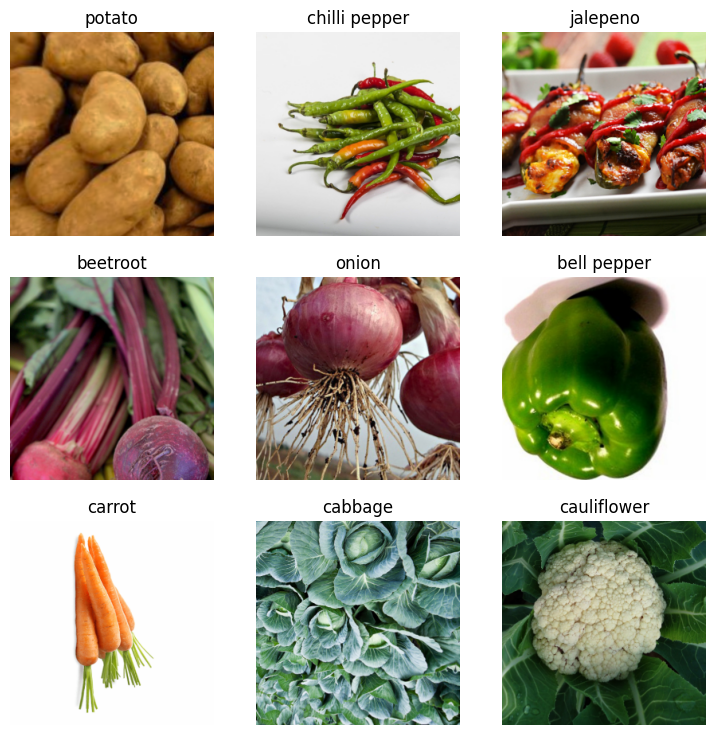

In [214]:
dls = db.dataloaders(path, bs=128, verbose=False)
dls.show_batch()

## Training a Model
### Callbacks

In [ ]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='modelResnet34_fruits_vegetables')
]
metrics = [accuracy, Precision(), Recall()]
learn = vision_learner(dls, resnet34, metrics=metrics,cbs=callbacks).to_fp16()

### Building the model

In [216]:
metrics = [accuracy, Precision(), Recall()]
learn = vision_learner(
    dls = dls,
    arch = resnet34,
    metrics = metrics,
    cbs = callbacks
).to_fp16()

### Learning Rate Finder

In [217]:
learn.lr_find()

c:\Users\elinf\OneDrive\Desktop\My_Files\06_UpWork\01_Projects\04_Image_classification\.venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\elinf\OneDrive\Desktop\My_Files\06_UpWork\01_Projects\04_Image_classification\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\elinf\OneDrive\Desktop\My_Files\06_UpWork\01_Projects\04_Image_classification\.venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\elinf\OneDrive\D

KeyboardInterrupt: 

Learning Rate Finder

### Fine-Tuning

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.929228,0.367284,0.853982,0.964630,0.845070,00:51


Better model found at epoch 0 with valid_loss value: 0.36728355288505554.


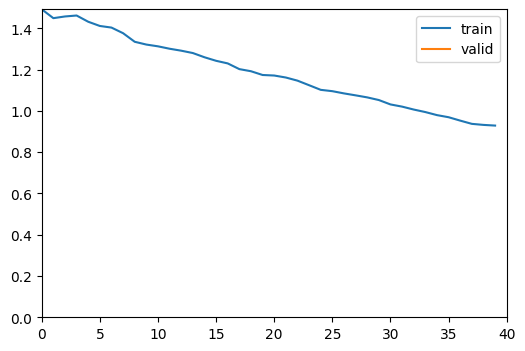

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.562527,0.288412,0.889381,0.960725,0.895775,00:50
1,0.427727,0.179554,0.945796,0.955862,0.976056,00:50
2,0.323006,0.145258,0.953540,0.957534,0.984507,00:50
3,0.264503,0.138683,0.955752,0.958904,0.985915,00:50
4,0.223876,0.126605,0.960177,0.959128,0.991549,00:50
5,0.184648,0.130236,0.962389,0.960490,0.992958,00:49
6,0.161477,0.117354,0.966814,0.968320,0.990141,00:49
7,0.155366,0.118970,0.964602,0.961853,0.994366,00:50
8,0.143609,0.116665,0.963496,0.961801,0.992958,00:50
9,0.142724,0.114814,0.969027,0.967123,0.994366,00:50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 0 with valid_loss value: 0.28841233253479004.


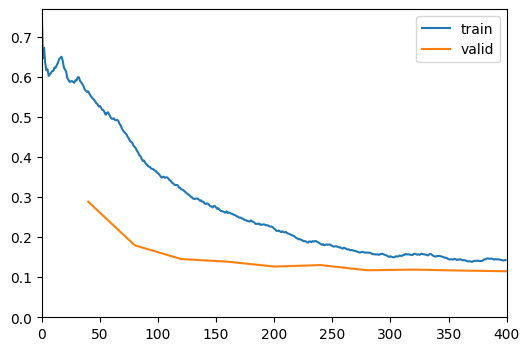

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 1 with valid_loss value: 0.17955376207828522.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 2 with valid_loss value: 0.14525753259658813.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 3 with valid_loss value: 0.13868258893489838.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 4 with valid_loss value: 0.12660472095012665.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 6 with valid_loss value: 0.11735384166240692.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 8 with valid_loss value: 0.11666486412286758.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 9 with valid_loss value: 0.11481406539678574.


In [ ]:
learn.fine_tune(10,base_lr=0.0008317637839354575)

In the Models folder we keep the best built model.

In [ ]:
Path('models').ls()

(#2) [Path('models/modelResnet18.pth'),Path('models/modelResnet18_Docknet.pth')]

We export the model.

In [ ]:
learn.to_fp32()
learn.export()

We can see that this model has kept in the same directory where we are.

In [ ]:
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### evaluating the model in the test set

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256,min_scale=0.75, max_rotate=15, flip_vert = True),
                             Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=128)


In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 0 with valid_loss value: 0.9656716585159302.


(#4) [0.12857210636138916,0.9656716585159302,0.9674502712477396,0.9907407407407407]

## Interpretation of the model

In [ ]:
learn.dls=dls

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


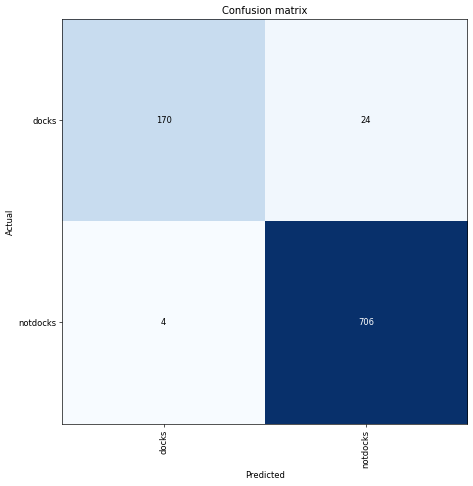

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8),dpi=60)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


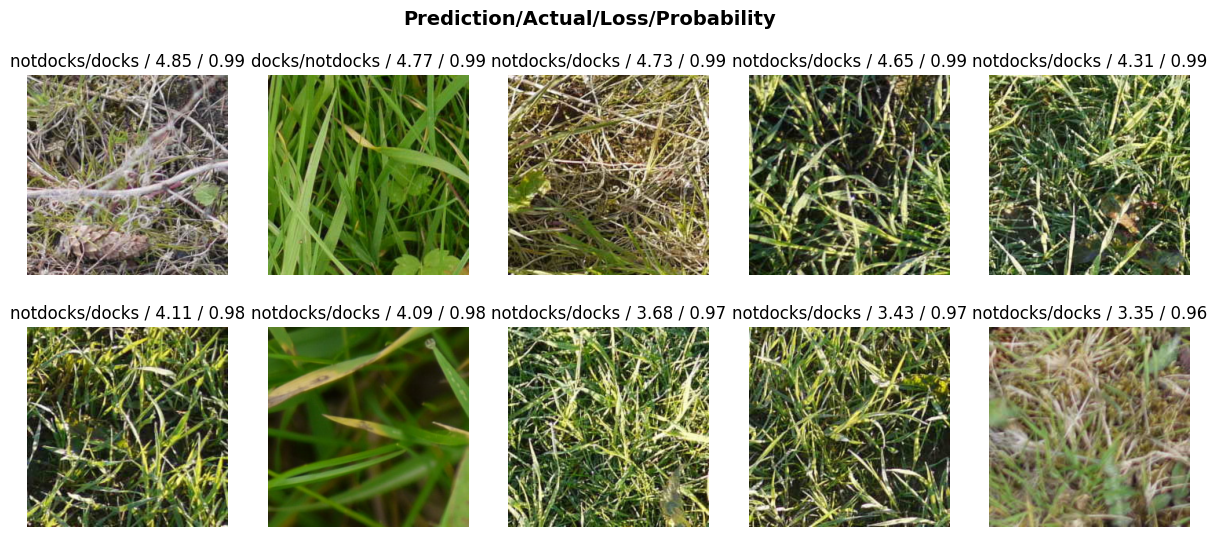

In [ ]:
interp.plot_top_losses(10,nrows=2)

In [ ]:
learn_inf = load_learner('export.pkl')

In [ ]:
learn_inf.predict('Docknet/test/docks/1038_31199_2068.jpg')

('docks', tensor(0), tensor([9.9999e-01, 1.2982e-05]))

## Creating an application for our model

In [ ]:
!pip install huggingface_hub["fastai"] -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from huggingface_hub import push_to_hub_fastai

# repo_id = "YOUR_USERNAME/YOUR_LEARNER_NAME"
# repo_id = "joheras/intel-image-classification"
repo_id = "el-filatova/Practica1"
push_to_hub_fastai(learner=learn, repo_id=repo_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  # Means the user did not define a `HF_TOKEN` secret => warn


model.pkl:   0%|          | 0.00/87.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/el-filatova/Practica1/commit/db7eb75272d12e5c804a3c1a9f2553c894814f31', commit_message='Push FastAI model using huggingface_hub.', commit_description='', oid='db7eb75272d12e5c804a3c1a9f2553c894814f31', pr_url=None, pr_revision=None, pr_num=None)